# Assignment 5

Deadline: 11.06.2025 12:00 CEST

<Add your name, student-id and emal address>
* Zihan Liu, 22-736-938, zihan.liu@uzh.ch
* Yujie Tao, 23-744-378, yujie.tao@uzh.ch
* Weijie Chen, 23-743-727, weijie.chen@uzh.ch
* Schmidli Adrian, 17-728-833, adrian.schmidli@uzh.ch

## Task

Develop an investment strategy for the Swiss equity market, backtest it using the provided datasets (`market_data.parquet`, `jkp_data.parquet`, `spi_index.csv`) and analyze its performance by benchmarking it against the SPI index. Work with the existing code infrastructure (`qpmwp-course`) and extend it by implementing any additional components needed for the strategy. Write a report that presents your methodology and the results.

### Coding (15 points)

- Selection:
  Implement selection item builder functions (via `SelectionItemBuilder`) to filter stocks based on specific criteria (e.g., exclude low-quality or high-volatility stocks).

- Optimization Data & Constraints:
  Implement functions to prepare optimization data (via `OptimizationItemBuilder`), including any econometric or machine learning-based predictions. These functions should also define optimization constraints (e.g., stock, sector, or factor exposure limits).

- Optimization Model:
  If you choose to create a custom optimization model, develop a class inheriting from Optimization (similar to `MeanVariance`, `LeastSquares`, or `BlackLitterman`). Your class should include methods set_objective and solve for defining the objective function and solving the optimization problem.

- Machine Learning Prediction:
  Integrate a machine learning model to estimate inputs for the optimization, such as expected returns or risk. This could include regression, classification, or learning-to-rank models. I suggest you to use the provided jkp_data as features, but you may also create your own (e.g., technical indicators computed on the return or price series).

- Simulation:
  Backtest the strategy and simulate portfolio returns. Account for fixed costs (1% per annum) and variable (transaction) costs (0.2% per rebalancing).


### Report (15 points):

Generate an HTML report with the following sections:

- High-level strategy overview: Describe the investment strategy you developed.

- Detailed explanation of the backtesting steps: Offer a more comprehensive breakdown of the backtesting process, including a description of the models implemented (e.g., details of the machine learning method used).

- Backtesting results:
    
    - Charts: Include visual representations (e.g., cumulative performance charts, rolling 3-year returns, etc.).
    - Descriptive statistics: Present key statistics such as mean, standard deviation, drawdown, turnover, and Sharpe ratio (or any other relevant metric) for the full backtest period as well as for subperiods (e.g., the last 5 years, or during bull vs. bear market phases).
    - Compare your strategy against the SPI index.


## Library and module imports:

In [5]:
# Standard library imports
import os
import sys
import copy
from typing import Union, Optional

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import empyrical as ep
from pprint import pprint
import itertools

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course\\src')    #<Change this path if needed>
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_data,
    bibfn_selection_data_random,
    bibfn_selection_ltr,
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_selection_jkp_single_factor_threshold,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

## Data load:

In [2]:
# Load data
path_to_data = "C:/Users/admin/OneDrive/Dokumente/Studium UZH/Master/5. Semester/Quantitative Portfolio Management with Python/Assingments/5. Assingment/1. Daten erhalten/" # <change this if necessary>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')
jkp_data = pd.read_parquet(path = f'{path_to_data}jkp_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
#print(data.market_data.head(10))
#print(data.market_data.tail(10))

data.jkp_data = jkp_data
#print(data.jkp_data.head(10))
#print(data.jkp_data.tail(10))

data.bm_series = load_data_spi(path='../data/')  # <change this if necessary>
# "load_data_spi" is a function defined in the class "helper_functions" that loads the SPI index data.
# Explanation: Assigning the result to the attribute "bm_series" of the object "data".
#print(data.bm_series.head(10))
#print(data.bm_series.tail(10))

# Separate attributes and methods of any object
def get_attrs_and_methods(obj):
    attributes = []
    methods = []
    for name in dir(obj): # The dir() function returns a list of all attributes (like data, market_data, etc.), methods (like get_return_series(), get_volume_series()) and special methods (like __init__, __str__, etc.) of an object.
        if name.startswith("__") and name.endswith("__"): # If the condition is true "continue" tells Python to skip the rest of the code in the loop body for that item and move on to the next name.
            continue  # Skip special methods
        attr = getattr(obj, name)
        if callable(attr): # Checks whether an object can be called like a function.
            methods.append(name)
        else:
            attributes.append(name)
    return attributes, methods

data_info = get_attrs_and_methods(data)
print(data_info)

# Print the loaded data
print("Market data:")
print(data.market_data.head(10))
print(data.market_data.tail(10))

# Get the return series:
print("Market data (return_series):")
returns = data.get_return_series()
print(returns.head(10))
print(returns.tail(10))

# Get the volume series:
print("Market data (volume_series):")
volumes = data.get_volume_series()
print(volumes.head(10))
print(volumes.tail(10))

# Get the characteristic_series:
print("JKP data (columns characteristic_series):")
print(data.jkp_data.columns.tolist())

def print_characteristic_series(field_name):
    characteristic = data.get_characteristic_series(field=field_name)
    print(f"\nMarket data for field: '{field_name}'")
    print("First 10 rows:")
    print(characteristic.head(10))
    print("\nLast 10 rows:")
    print(characteristic.tail(10))
    return characteristic

z_series = print_characteristic_series("z_score")
print("\nNaN's in z_score:", z_series.isna().sum().sum())
f_series = print_characteristic_series("f_score")
print("\nNaN's in f_score:", f_series.isna().sum().sum())
o_series = print_characteristic_series("o_score")
print("\nNaN's in o_score:", o_series.isna().sum().sum())

print("Benchmark series (SPI Index):")
print(data.bm_series.head(10))
print(data.bm_series.tail(10))

(['bm_series', 'jkp_data', 'market_data'], ['get_characteristic_series', 'get_return_series', 'get_volume_series'])
Market data:
               price        mktcap  liquidity sector
date       id                                       
1999-05-06 1   461.0  1.235952e+09   129080.0   None
1999-05-07 1   455.0  1.219866e+09     4550.0   None
1999-05-10 1   455.0  1.219866e+09      910.0   None
1999-05-11 1   460.0  1.233271e+09     4600.0   None
1999-05-12 1   460.0  1.233271e+09      460.0   None
1999-05-14 1   460.0  1.233271e+09     4600.0   None
1999-05-19 1   460.0  1.233271e+09     2300.0   None
1999-05-21 1   460.0  1.233271e+09     4600.0   None
1999-05-26 1   460.0  1.233271e+09    13800.0   None
1999-05-31 1   463.0  1.241314e+09    13890.0   None
                    price      mktcap  liquidity sector
date       id                                          
2024-04-17 313   9.814924  20167830.0        0.0   None
2024-04-18 313   9.814924  20167830.0        0.0   None
2024-04-19 

## Definition of rebalancing dates:

In [3]:
# Define rebalancing dates
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
print(market_data_dates)
# 1.) Taking out the "date" index of the market data.
# 2.) Getting the unique dates out of it (because the most dates are repeatedly in the "date" index due to several company ID's).
# 3.) Sorting the unique dates in ascending order.

starting_point = '2015-01-01'  # Define the starting point for the rebalancing dates.
n_days = 21*3 # Rebalance every 3 months (21 trading days per month).
rebdates = market_data_dates[market_data_dates > starting_point][::n_days].strftime('%Y-%m-%d').tolist()
# It would be possible to adjust these parameters (n_days, starting_point) to change the rebalancing frequency.
# We leave it like they are, because of comparability between the different investment strategies.
print(rebdates) # This is the list of rebalancing dates.

DatetimeIndex(['1985-12-31', '1986-01-01', '1986-01-02', '1986-01-03',
               '1986-01-06', '1986-01-07', '1986-01-08', '1986-01-09',
               '1986-01-10', '1986-01-13',
               ...
               '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22',
               '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
               '2024-04-29', '2024-04-30'],
              dtype='datetime64[ns]', name='date', length=9979, freq=None)
['2015-01-02', '2015-04-01', '2015-06-29', '2015-09-24', '2015-12-22', '2016-03-18', '2016-06-15', '2016-09-12', '2016-12-08', '2017-03-07', '2017-06-02', '2017-08-30', '2017-11-27', '2018-02-22', '2018-05-22', '2018-08-17', '2018-11-14', '2019-02-11', '2019-05-09', '2019-08-06', '2019-11-01', '2020-01-29', '2020-04-27', '2020-07-23', '2020-10-20', '2021-01-15', '2021-04-14', '2021-07-12', '2021-10-07', '2022-01-04', '2022-04-01', '2022-06-29', '2022-09-26', '2022-12-22', '2023-03-21', '2023-06-16', '2023-09-13', '2023-12-11', '2

## Definition of the selection item builders:

In [ ]:
# Define the selection item builders
selection_item_builder_no_selection = SelectionItemBuilder(bibfn = bibfn_selection_data)

selection_item_builders_random_selection = {}
sample_size = [10, 20, 30, 40, 50]
seed = 7 # Seed for reproducibility of random selection.
for k in sample_size:
    builder_name = f"selection_item_builder_random_selection_k{k}"
    selection_item_builders_random_selection[builder_name] = SelectionItemBuilder(
        bibfn = bibfn_selection_data_random,
        k = k,
        seed = seed
    )

# Define parameter spaces
lookback_years = [1, 2, 3, 4, 5]
min_volume_options = [100_000, 300_000, 500_000, 1_000_000] # For an interpretation of the chosen levels look below.
agg_fn_options = [np.mean, np.median, np.max, np.min]  # Aggregation functions for volume.
z_score_thresholds = [1.81, 2.99] # For an interpretation of the chosen levels look below.
n_days_options = [1, 3, 5, 10, 20] # For an interpretation of the chosen levels look below.

# All keys we may use
keys = ['gaps', 'min_volume', 'z_score'] 

# All non-empty combinations of the keys
all_key_combinations = []
for r in range(1, len(keys) + 1): # For example: range(1, 4) → [1, 2, 3].
    all_key_combinations.extend(itertools.combinations(keys, r)) 
# r= 1 does all combinations with just one key (e.g., ["gaps"] or ["min_volume"] etc.), r=2 does all combinations with two keys (e.g., ["gaps", "min_volume"] or ["min_volume", "z_score"]), etc.

# Store all generated configurations
selection_combinations = []

for key_combo in all_key_combinations:
    for k in lookback_years:
        for min_vol in min_volume_options:
            for agg_fn in agg_fn_options:
                for z_thr in z_score_thresholds:
                    for nd in n_days_options:

                        # Build config dynamically
                        selection_item_builders_chosen_selection = {}

                        if 'gaps' in key_combo:
                            selection_item_builders_chosen_selection['gaps'] = SelectionItemBuilder(
                                bibfn=bibfn_selection_gaps,
                                width=252 * k,
                                n_days=nd,
                            )

                        if 'min_volume' in key_combo:
                            selection_item_builders_chosen_selection['min_volume'] = SelectionItemBuilder(
                                bibfn=bibfn_selection_min_volume,
                                width=252 * k,
                                min_volume=min_vol,
                                agg_fn=agg_fn,
                            )

                        if 'z_score' in key_combo:
                            selection_item_builders_chosen_selection['z_score'] = SelectionItemBuilder(
                                bibfn=bibfn_selection_jkp_single_factor_threshold,
                                fields='z_score',
                                width=252 * k,
                                threshold=z_thr,
                                operator_str='>',
                            )

                        # Save or process this configuration
                        selection_combinations.append(selection_item_builders_chosen_selection)

print(f"Total generated combinations: {len(selection_combinations)}")








selection_item_builders_chosen_selection = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*k, # look-back window.
        n_days = 10,
    ),
    # Drops elements from the selection when there is a gap of more than "n_days" (i.e., consecutive zero's) within one look-back window ("width") in the volume (i.e., "liquidity") series.
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252*k, # look-back window.
        min_volume = 500_000, # The same as 500'000.
        agg_fn = np.median,
    ),
    # Filter stocks based on their median volume (< min_volume) within one look-back window ("width") in the volume (i.e., "liquidity") series.
    'z_score': SelectionItemBuilder(
        bibfn = bibfn_selection_jkp_single_factor_threshold,
        fields = 'z_score', # Selected because of the highest data availability relative to the other comparable scores like "f_score" and "o_score".
        width = 252*k, # look-back window.
        threshold = 2.99, # Interpretation of the threshold: look below.
        operator_str = '>', 
    ),
    # Filter stocks based on their z-score latest within one look-back window ("width").
}


# Define the selection item builders (LTR)
selection_item_builder_no_selection = {
    'ltr': SelectionItemBuilder(bibfn = bibfn_selection_ltr),
    # This selection item builder is required to create the test data for the learning-to-rank (LTR) model.
    'no_selection': SelectionItemBuilder(bibfn = bibfn_selection_data)
    # This selection item builder does not apply any selection criteria and uses the full dataset. 
}

selection_item_builders_random_selection = {}
sample_size = [10, 20, 30, 40, 50]
seed = 7 # Seed for reproducibility of random selection.
for k in sample_size:
    builder_name = f"selection_item_builder_random_selection_k{k}"
    selection_item_builders_random_selection[builder_name] = SelectionItemBuilder(
        bibfn = bibfn_selection_data_random,
        k = k,
        seed = seed
    )

selection_item_builder_ltr= SelectionItemBuilder(bibfn = bibfn_selection_ltr)

selection_item_builders_chosen_selection = {
    'ltr': SelectionItemBuilder(bibfn = bibfn_selection_ltr),
    # 
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3, # three years look-back window
        n_days = 10,
    ),
    # Drops elements from the selection when there is a gap of more than "n_days" (i.e., consecutive zero's) within one look-back window ("width") in the volume (i.e., "liquidity") series.
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252, # one year look-back window.
        min_volume = 500_000, # The same as 500'000.
        agg_fn = np.median,
    ),
    # Filter stocks based on their median volume (< min_volume) within one look-back window ("width") in the volume (i.e., "liquidity") series.
    'z_score': SelectionItemBuilder(
        bibfn = bibfn_selection_jkp_factor_scores,
        fields = 'z_score', # Selected because of the highest data availability relative to the other comparable scores like "f_score" and "o_score". 
        min_score = 2.99,
    ),
    # Filter stocks based on their z-score (i.e., "z_score") within the JKP factor scores.
}


selection_item_builders = {"selection_item_builder_no_selection": selection_item_builder_no_selection,
                           "selection_item_builders_random_selection": selection_item_builders_random_selection,
                           "selection_item_builder_ltr": selection_item_builder_ltr,
                           "selection_item_builders_chosen_selection": selection_item_builders_chosen_selection}
pprint(selection_item_builders)

{'selection_item_builder_no_selection': <backtesting.backtest_item_builder_classes.SelectionItemBuilder object at 0x0000025472DB08D0>,
 'selection_item_builders_random_selection': {'selection_item_builder_random_selection_k10': <backtesting.backtest_item_builder_classes.SelectionItemBuilder object at 0x000002547A52E910>,
                                              'selection_item_builder_random_selection_k20': <backtesting.backtest_item_builder_classes.SelectionItemBuilder object at 0x0000025472E4EB10>,
                                              'selection_item_builder_random_selection_k30': <backtesting.backtest_item_builder_classes.SelectionItemBuilder object at 0x0000025472E4F910>,
                                              'selection_item_builder_random_selection_k40': <backtesting.backtest_item_builder_classes.SelectionItemBuilder object at 0x0000025472E4EBD0>,
                                              'selection_item_builder_random_selection_k50': <backtesting.backtes

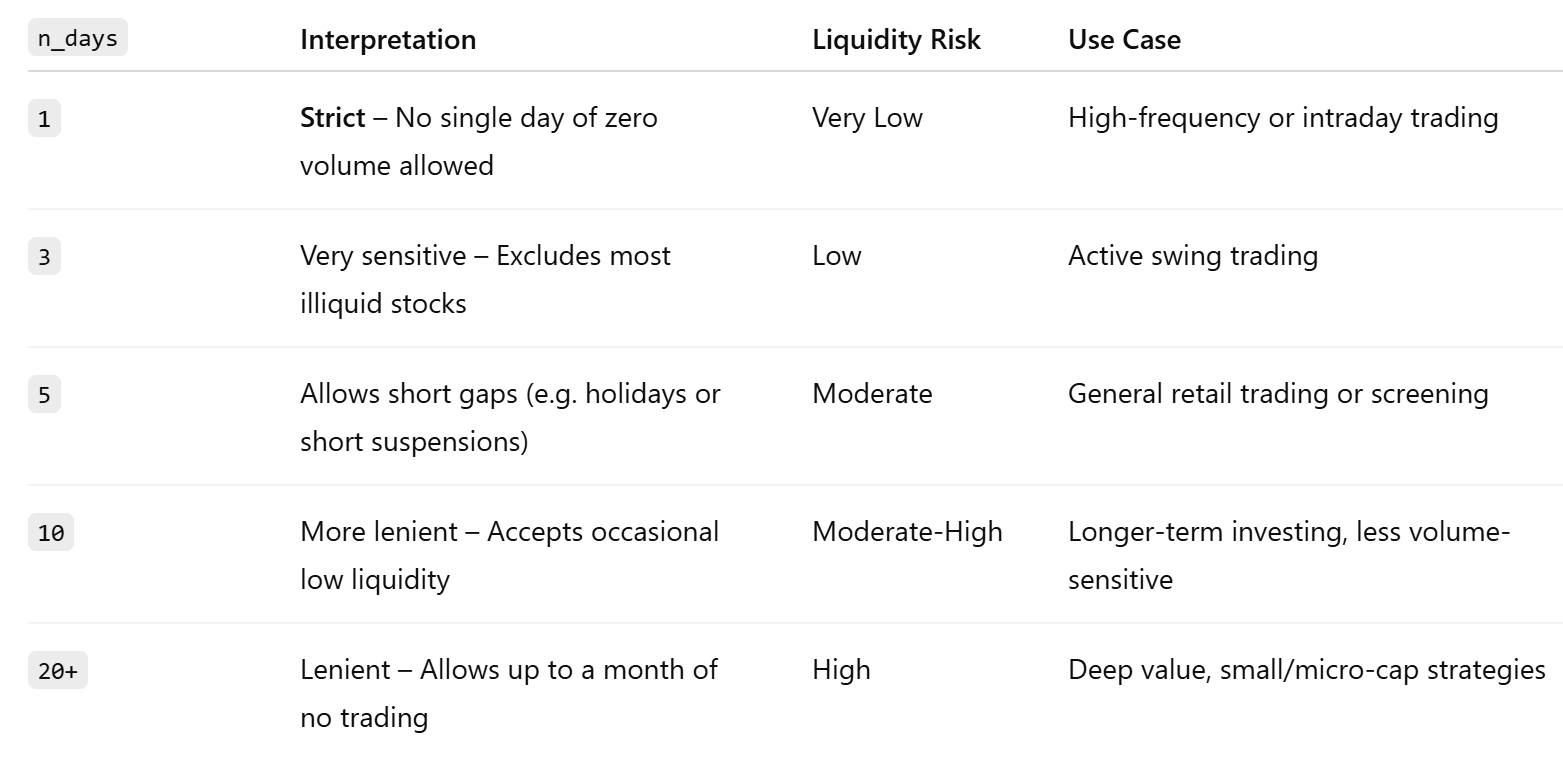
![WhatsApp Image 2025-05-27 at 09.22.51_56701425.jpg](<attachment:WhatsApp Image 2025-05-27 at 09.22.51_56701425.jpg>)
![WhatsApp Image 2025-05-26 at 17.43.28_27364671.jpg](<attachment:WhatsApp Image 2025-05-26 at 17.43.28_27364671.jpg>)
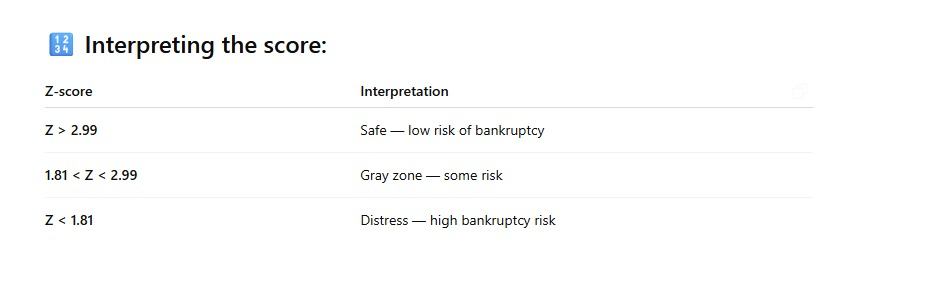
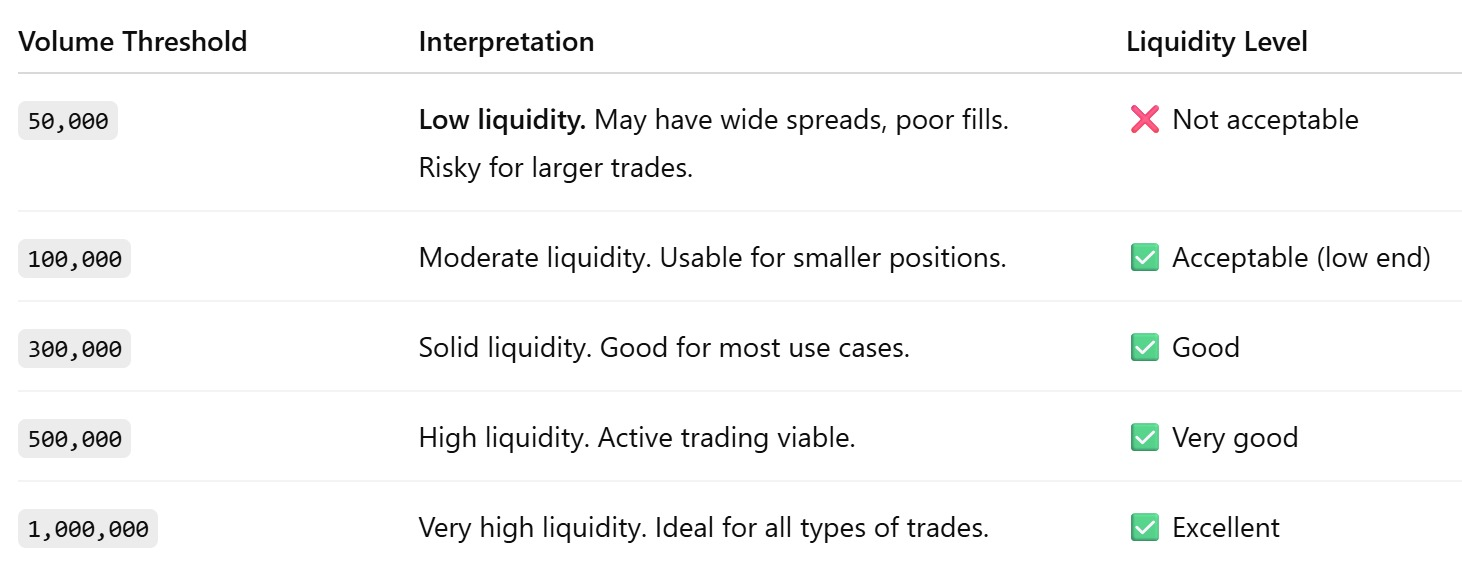

## Definition of the optimization item builders:

3


## Initialization of the backtest service:

In [ ]:
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)